In [53]:
# Copy Library File
!cp drive/MyDrive/SampleMLData/basic_library.py .

from numpy import vstack
from pandas import read_csv
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch import Tensor, from_numpy
from torch.nn import Linear, ReLU, Sigmoid, Module, BCELoss
from torch.optim import Adam
from collections import defaultdict
from tqdm.notebook import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import random

# GPU Training Explanation + Instructions on Local Running
- We can allow students to utilize either Colab or their own resources by explaining how this cell works and how the code moves tensors to the GPU.

In [54]:
"""
This cell displays the machine's GPU Information
If you are utilizing a machine with multiple GPUs change the device_num until the correct one is displayed.
Google Colab should always use device 0.
"""
device_num = 0
print("Number of GPUs Available: ", torch.cuda.device_count())
print("Name of Selected GPU: ", torch.cuda.get_device_name(device_num))
device = torch.device(f"cuda:{device_num}" if torch.cuda.is_available() else "cpu")

Number of GPUs Available:  1
Name of Selected GPU:  Tesla K80


#Some Helper Functions
We can move these functions to a separate .py file so students don't mess with them. Or we can let students edit these if they're interested in manipulating the dataset more as its being loaded.

In [55]:
"""
Dataset Definition
"""
class ProblemDataset(Dataset):
    def __init__(self, path):
        # Load CSV as Pandas Dataframe
        df = read_csv(path, header=0)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        self.X = self.X.astype('float32')
        self.y = self.y.astype('float32')
 
    # Returns number of rows in dataset
    def __len__(self):
        return len(self.X)
 
    # Returns an individual row in the dataset
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # Get indices for training/validation/testing splits.
    # This is stratified by the y value, meaning equal distribution of pos/neg
    def get_splits(self, n_test=0.2):
        # TODO: Possibly add ability to define validation size
        x_train, x_holdout, y_train, y_holdout = train_test_split(self.X, self.y, test_size=2*n_test, stratify=self.y)
        x_val, x_test, y_val, y_test = train_test_split(x_holdout, y_holdout, test_size=0.5, stratify= y_holdout)
        train_dataset = TensorDataset(from_numpy(x_train), from_numpy(y_train))
        valid_dataset = TensorDataset(from_numpy(x_val), from_numpy(y_val))
        test_dataset = TensorDataset(from_numpy(x_test), from_numpy(y_test))
        return train_dataset, valid_dataset, test_dataset

"""
Creates the dataloaders for the train/validation/test sets
"""
def create_dataloaders(path):
    # Load the dataset
    dataset = ProblemDataset(path)
    # Create the train/validation/testing splits
    train, validation, test = dataset.get_splits()
    # Prepare the Data Loaders
    train_dl = DataLoader(train, batch_size=32, shuffle=True)
    validation_dl = DataLoader(validation, batch_size=1024, shuffle=False)
    test_dl = DataLoader(test, batch_size=1024, shuffle=False)
    return train_dl, validation_dl, test_dl

def evaluate_predictions(y, yhat):
    yhat, y = vstack(yhat), vstack(y)
    acc = accuracy_score(y, yhat)
    auc = roc_auc_score(y, yhat)
    recall = recall_score(y, yhat)
    prec = precision_score(y, yhat)
    return acc, auc, recall, prec
    
"""
Trains the model for X epochs.
"""
def train(train_dl, val_dl, model, total_epoch, criterion, optimizer):
    # Dictionary to keep track of the training statistics
    training_notes = defaultdict(list)
    for epoch in tqdm_notebook(range(total_epoch)):
        # enumerate mini batches
        actuals, predictions = list(), list()
        for i, (inputs, targets) in enumerate(train_dl):
            inputs, targets = inputs.to(device), targets.to(device)
            # Clear the Gradients
            optimizer.zero_grad()
            # Compute the Model Predictions
            yhat = model(inputs)
            # Calculate Loss
            targets = targets.unsqueeze(1)
            loss = criterion(yhat, targets)
            # Update Model Weights
            loss.backward()
            optimizer.step()
            # Store actual and Predictions for Evaluation
            yhat = yhat.cpu().detach().numpy().round()
            actual = targets.cpu().numpy()
            actual = actual.reshape((len(actual), 1))
            predictions.append(yhat)
            actuals.append(actual)
        acc, auc, recall, prec = evaluate_predictions(actuals, predictions)
        training_notes['train_acc'].append((epoch, acc))
        training_notes['train_auc'].append((epoch, auc))
        training_notes['train_recall'].append((epoch, recall))
        training_notes['train_precision'].append((epoch, prec))
        acc, auc, recall, prec = evaluate_model(val_dl, model)
        training_notes['val_acc'].append((epoch, acc))
        training_notes['val_auc'].append((epoch, auc))
        training_notes['val_recall'].append((epoch, recall))
        training_notes['val_precision'].append((epoch, prec))
    return training_notes
 
"""
Evaluates the models against another dataset.
"""
def evaluate_model(eval_dl, model):
    actuals, predictions = list(), list()
    for i, (inputs, targets) in enumerate(eval_dl):
        # Evaluate the model against the given dataset
        inputs = inputs.to(device)
        targets = targets.to(device)
        yhat = model(inputs)
        # Store actual and predictions for Evaluation
        yhat = yhat.cpu().detach().numpy().round()
        actual = targets.cpu().numpy()
        actual = actual.reshape((len(actual), 1))
        predictions.append(yhat)
        actuals.append(actual)
    acc, auc, recall, prec = evaluate_predictions(actuals, predictions)
    return acc, auc, recall, prec

"""
Makes a prediction for one row of data
"""
def predict(x, model):
    # Create a tensor from row of data
    x = Tensor([x])
    # Run model on data
    yhat = model(x)
    # Retrieve Prediction
    yhat = yhat.detach().numpy().round()
    return yhat

# Model for Students to Edit
- Allow students to experiment with different model structures
- Allow them to try different optimizers and loss types
- Change hyperparameters? Epochs are currently adjustable.
- We can simply link to the Pytorch documentation if they're interested in looking at all of the available structures/optimization parameters.
  - https://pytorch.org/docs/stable/nn.html

In [56]:
# Optimization Definition
def train_model(train_dl, validation_dl, model):
    # Define Optimization Parameters
    criterion = BCELoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    epochs = 100
    training_notes = train(train_dl, validation_dl, model, epochs, criterion, optimizer)
    return training_notes

# Model Definition
class Net(Module):
    # Define the structure here
    def __init__(self, n_inputs):
        super(Net, self).__init__()
        # Hidden Layer
        self.hidden = Linear(n_inputs, 4)
        self.act = ReLU()
        # Output Layer
        self.output = Linear(4, 1)
        self.final_output = Sigmoid()
 
    # Define the order for the structure
    def forward(self, X):
        """
        The current structure takes an input Tensor of size [32, 13].
        It is transformed into a Tensor of size [32, 4] using linear transformations
        Then transformed into a Tensor of size [32, 2] using linear transformations
        Then transformed into a Tensor of size [32, 1] using the Sigmoid function
        """
        # Hidden Layer
        X = self.hidden(X)
        X = self.act(X)
        # Output Layer
        X = self.output(X)
        X = self.final_output(X)
        return X

# Main Function
- We should be loading the dataset for them and calling some basic functions.

In [57]:
# Define a Training Seed (So your group can reproduce your numbers later :))
seed = 494598
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
# Prepare the data
# Currently network size is passed in until we determine what exact dataset to utilize
path = 'drive/MyDrive/SampleMLData/wine.csv'
model = Net(11)
#path = 'drive/MyDrive/SampleMLData/covid_dataset_preprocessed.csv'
#model = Net(20) # Covid Data
train_dl, validation_dl, test_dl = create_dataloaders(path)
print("Training Data Count: ", len(train_dl.dataset))
print("Validation Data Count: ", len(validation_dl.dataset))
print("Testing Data Count: ", len(test_dl.dataset))
model.to(device)
# Train the model
print("Starting Model Training...")
start = time.time()
training_notes = train_model(train_dl, validation_dl, model)
end = time.time()
print("Finished Training Model")
print('Training Time: ', time.strftime("%Hh %Mm %Ss", time.gmtime(end - start)))
# Evaluate the model
acc, auc, recall, prec = evaluate_model(test_dl, model)
print('\nModel Test Set Performance Statistics:')
print('Test Set Accuracy:\t %.3f' % acc)
print('Test Set AUC:\t\t %.3f' % auc)
print('Test Set Recall:\t %.3f' % recall)
print('Test Set Precision:\t %.3f' % prec)

Training Data Count:  959
Validation Data Count:  320
Testing Data Count:  320
Starting Model Training...


  0%|          | 0/100 [00:00<?, ?it/s]

Finished Training Model
Training Time:  00h 00m 07s

Model Test Set Performance Statistics:
Test Set Accuracy:	 0.781
Test Set AUC:		 0.778
Test Set Recall:	 0.830
Test Set Precision:	 0.776


#Basic Evaluation and Analysis
- Contains some basic stats regarding their model's performace
- Students interested in data science can create some extra figures in a cell below.

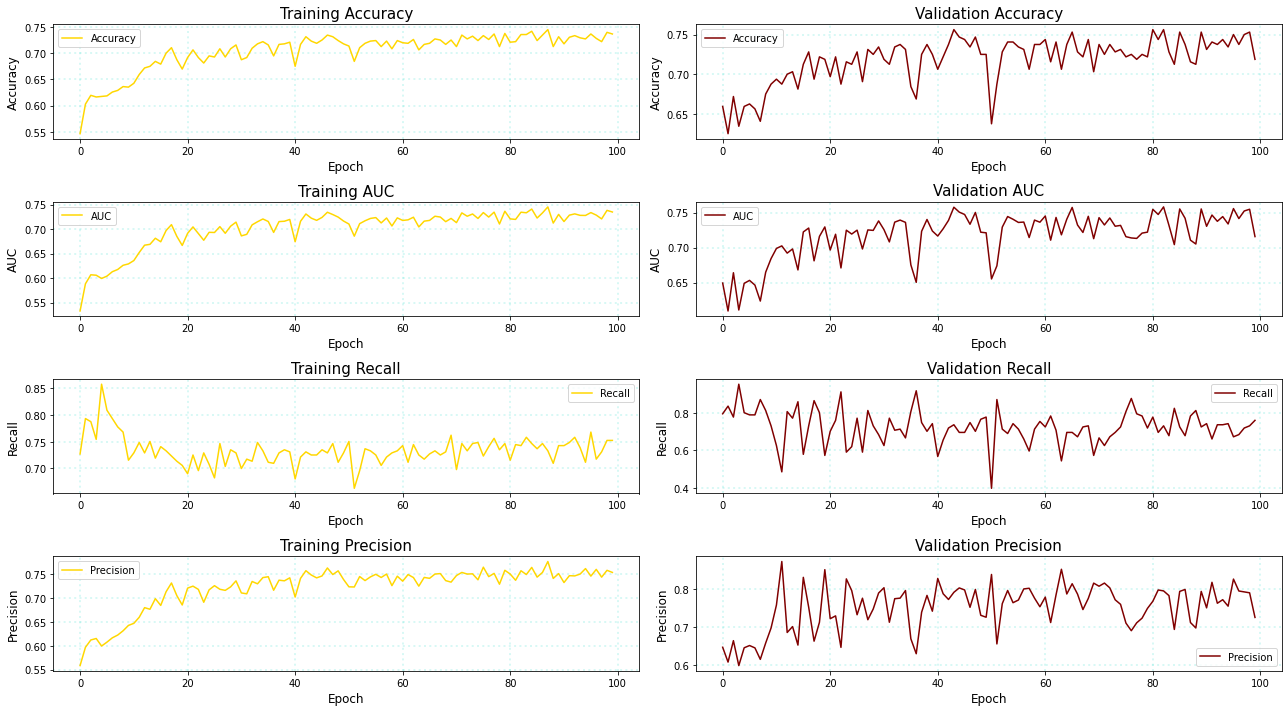

In [58]:
# Show Recall Precision
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(18, 10))

def plot_measure_graph(x_data, y_data, ax, title="Generic Title", color="Black", parameter="Generic Measure"):
    ax.plot(x_data, y_data, label=parameter, color=color)
    ax.set_title(title, fontsize=15)
    ax.set_xlabel('Epoch', fontsize=12)
    ax.set_ylabel(parameter, fontsize=12)
    ax.grid(b=True, color="Turquoise", alpha=0.2, linestyle=':', linewidth=2)
    ax.legend()

train_acc_x, train_acc_y = zip(*training_notes['train_acc'])
val_acc_x, val_acc_y = zip(*training_notes['val_acc'])
train_auc_x, train_auc_y = zip(*training_notes['train_auc'])
val_auc_x, val_auc_y = zip(*training_notes['val_auc'])
train_recall_x, train_recall_y = zip(*training_notes['train_recall'])
val_recall_x, val_recall_y = zip(*training_notes['val_recall'])
train_prec_x, train_prec_y = zip(*training_notes['train_precision'])
val_prec_x, val_prec_y = zip(*training_notes['val_precision'])

plot_measure_graph(train_acc_x, train_acc_y, ax=axs[0][0], title="Training Accuracy", color="Gold", parameter="Accuracy")
plot_measure_graph(val_acc_x, val_acc_y, ax=axs[0][1], title="Validation Accuracy", color="Maroon", parameter="Accuracy")
plot_measure_graph(train_auc_x, train_auc_y, ax=axs[1][0], title="Training AUC", color="Gold", parameter="AUC")
plot_measure_graph(val_auc_x, val_auc_y, ax=axs[1][1], title="Validation AUC", color="Maroon", parameter="AUC")
plot_measure_graph(train_recall_x, train_recall_y, ax=axs[2][0], title="Training Recall", color="Gold", parameter="Recall")
plot_measure_graph(val_recall_x, val_recall_y, ax=axs[2][1], title="Validation Recall", color="Maroon", parameter="Recall")
plot_measure_graph(train_prec_x, train_prec_y, ax=axs[3][0], title="Training Precision", color="Gold", parameter="Precision")
plot_measure_graph(val_prec_x, val_prec_y, ax=axs[3][1], title="Validation Precision", color="Maroon", parameter="Precision")
fig.tight_layout()
plt.show()